# Завдання

- Отримати навички роботи з базами знань.
- Удосконалити агента-автомобіля з попередньої лабораторної роботи.

# Опис алгоритму

Отже, на кожному перехресті є знак, який показує скільки доріг до нього ведуть.
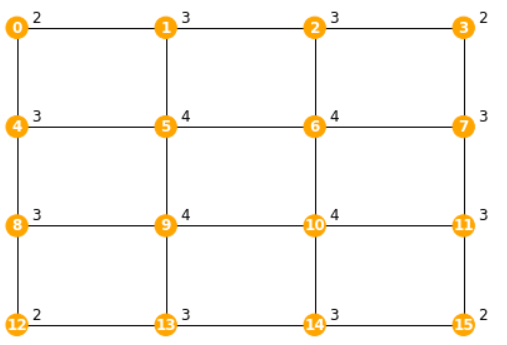

Удосконалення нашого алгоритму допомагає нам уникати перехресть, які введуть у глухий кут. Наприклад:
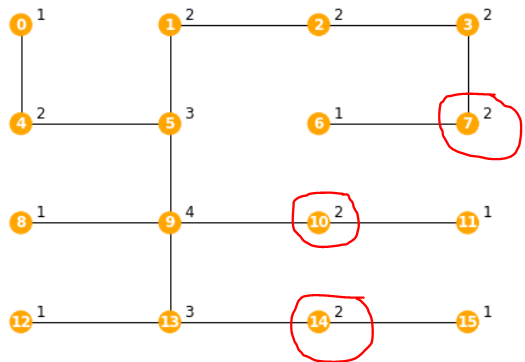

точки 7, 10, 14 не будуть навіть розглядатись як можливий варіант зупинки(звичайно, якщо вони не ведуть до фінішу).
За увесь процес відповідає ось цей код:
```python
for variant in variants:
            connections: list = list(self.G.edges(variant))
            flag = False
            for connection in connections:
                if connection[1] == end:
                    self.history.extend([variant, connection[1]])
                    return self.walking(end, connection[1])
                if self.labels[connection[1]] != 1 and connection[1] != self.active_node:
                    flag = True
            if not flag:
                bad_nodes.append(variant)
        for bad_node in bad_nodes:
            del variants[bad_node]
```
1. Спочатку беруться з'єднання з точкою нашої можливої зупинки.
2. Якщо вона веде до фінішу, одразу туди переїжджаємо.
3. Якщо вона веде у глухий кут, видаляємо із варіантів.

# Виконання

In [340]:
from typing import List, Dict
from random import choice
from copy import deepcopy
from math import sqrt

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [341]:
class Graph:
    shift = (0.1, 0.1)

    def __init__(self, n: int = 5):
        self.double_n = n * n
        self.n = n
        self.edgesList: List[list] = [[] for _ in range(self.double_n)]
        self.edges_n = 0
        self._create_edges()
        self.__make_graph()
        self.active_node = 0
        self.history = []
        self.good_nodes = []

    def _create_edges(self): 
        for start in range(self.double_n):
            for end in range(self.double_n):
                if abs(end - start) == self.n:
                    self.edgesList[start].append(end)
                    self.edges_n += 1
                if abs(end - start) == 1:
                    if (start % self.n == 0 and (end + 1) % self.n == 0) or (end % self.n == 0 and (start + 1) % self.n == 0):
                        continue
                    self.edgesList[start].append(end)
                    self.edges_n += 1

    def delete_edges(self, delete_n: int):
        if delete_n > self.edges_n / 2 + 1 - self.double_n:
            raise Exception(f'Delete number must be less or equal than {int(self.edges_n / 2 + 1 - self.double_n)}')
        for _ in range(delete_n):
            edges = []
            while True:
                temp_list = deepcopy(self.edgesList)
                edgesList_copy = deepcopy(self.edgesList)
                point = choice(range(len(temp_list)))
                connected_point = choice(temp_list[point])
                if [point, connected_point] in edges:
                  continue
                edges.append([point, connected_point])
                temp_list[point].remove(connected_point)
                temp_list[connected_point].remove(point)
                self.edgesList = temp_list
                if self.isStronglyConnected():
                    print(point, connected_point)
                    break
                self.edgesList = edgesList_copy
        self.edges_n -= delete_n * 2

    
    def _DFS(self, v, visited):
        visited[v] = True
        for u in self.edgesList[v]:
            if not visited[u]:
                self._DFS(u, visited)

    def isStronglyConnected(self):
        for i in range(self.double_n):
            visited = [False] * self.double_n
            self._DFS(i, visited)
            for b in visited:
                if not b:
                    return False
        return True

    def __make_graph(self):
        self.G=nx.Graph()
        self.positions = {}
        counter = 0
        for i in range(n-1, -1, -1):
          for j in range(n):
            self.G.add_node(counter)
            self.positions[counter] = (j, i)
            counter += 1
        for point, connections in enumerate(self.edgesList):
          for connection in connections:
            self.G.add_edge(point, connection)
    
    def __make_signs(self):
        self.labels: Dict[int, int] = {}
        self.shifted_positions = {id: (position[0] + self.shift[0], position[1] + self.shift[1]) for id, position in self.positions.items()}
        for index, connections in enumerate(self.edgesList):
            self.labels[index] = len(connections)
    
    def draw(self):
        self.__make_graph()
        self.__make_signs()
        colors = np.array(['orange'] * self.double_n)
        colors[self.history] = 'red'        
        nx.draw(self.G, pos=self.positions, node_color=colors, with_labels=True, font_weight='bold', font_color='white')
        nx.draw_networkx_labels(self.G, self.shifted_positions, labels=self.labels, horizontalalignment="left")
        plt.show()

    def walking(self, end: int, start: int = None):
        if start is not None:
            self.active_node = start
        if not self.history:
            self.history.append(self.active_node)
        x1, y1 = self.positions[self.active_node]
        x2, y2 = self.positions[end]
        d = sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)
        if d == 0.0:
            self.draw()
            print('History: ', self.history)
            print('You have ended the walk')
            self.active_node = 0
            self.history = []
            self.good_nodes = []
            return
        variants = {}
        edges = list(self.G.edges(self.active_node))
        if len(edges) >= 2:
            if any(edge[1] not in self.history for edge in edges):
                self.good_nodes.append(self.active_node)
        for edge in edges:
            edge_on_end = edge[1]
            if not edge_on_end in self.history:
                x1, y1 = self.positions[edge_on_end]
                d = sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)
                variants[edge[1]] = d
        variants = dict(sorted(variants.items(), key=lambda item: item[1]))
        bad_nodes = []
        for variant in variants:
            connections: list = list(self.G.edges(variant))
            flag = False
            for connection in connections:
                if connection[1] == end:
                    self.history.extend([variant, connection[1]])
                    return self.walking(end, connection[1])
                if self.labels[connection[1]] != 1 and connection[1] != self.active_node:
                    flag = True
            if not flag:
                bad_nodes.append(variant)
        for bad_node in bad_nodes:
            del variants[bad_node]
        if not variants:
            next_pos = self.good_nodes.pop(0)
        else:
            next_pos = list(variants.keys())[0]
        self.history.append(next_pos)
        return self.walking(end, next_pos)


## Ініціалізація графу

In [342]:
n = 4

In [343]:
graph = Graph(n)

## Відображення графу

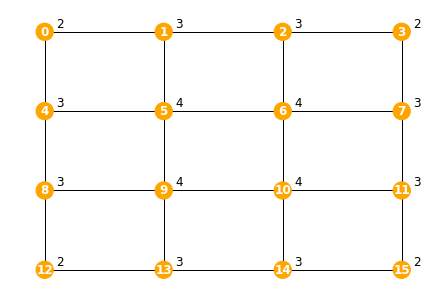

In [344]:
graph.draw()

## Видалення ребер

In [345]:
graph.delete_edges(9)

15 11
7 3
2 1
11 10
12 13
13 14
0 4
9 8
9 10


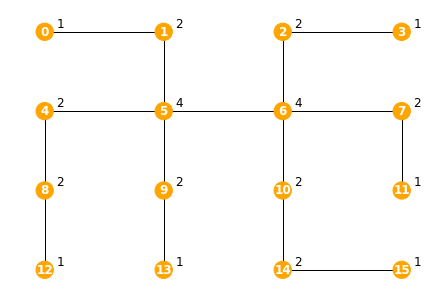

In [346]:
graph.draw() 

## Тестування проходження шляху

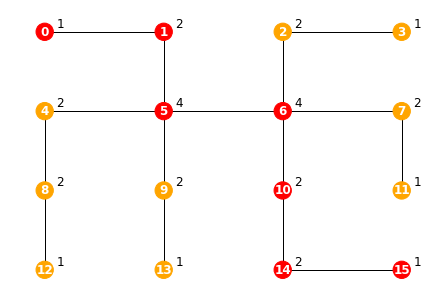

History:  [0, 1, 5, 6, 10, 14, 15]
You have ended the walk


In [347]:
graph.walking(end=15)

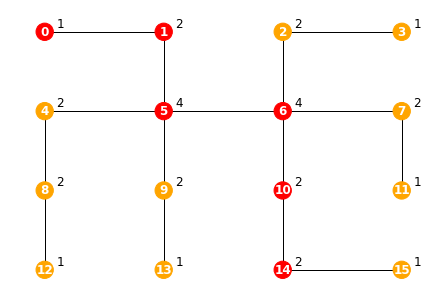

History:  [0, 1, 5, 6, 10, 14]
You have ended the walk


In [348]:
graph.walking(14)

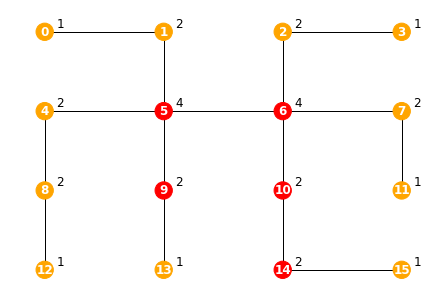

History:  [9, 5, 6, 10, 14]
You have ended the walk


In [349]:
graph.walking(14, 9)

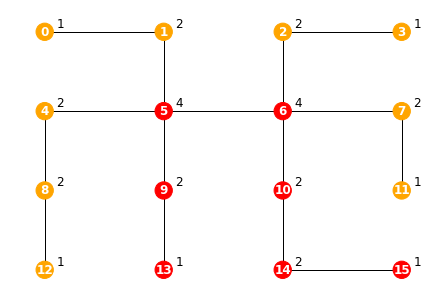

History:  [15, 14, 10, 6, 5, 9, 13]
You have ended the walk


In [350]:
graph.walking(13, 15)

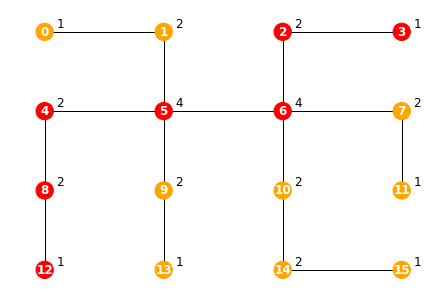

History:  [12, 8, 4, 5, 6, 2, 3]
You have ended the walk


In [351]:
graph.walking(3, 12)

# Висновок

Я на практиці ознайомився із терміном агент на основі знань та як він впливає, а саме покращує, на роботу агенту. Мій алгоритм значно підвищує ефективність вибору точок, а також зменшує час проходження усього шляху.